In [1]:
import pandas as pd
import numpy as np
import os
import sys

from PIL import Image, ImageFilter, ImageOps
from matplotlib import pyplot as plt

### Modeling
from sklearn.ensemble import IsolationForest

import tensorflow as tf
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, model_from_json

###### Checking files in each directory

- Mask inside test directory has labels for anomalies

In [2]:
print(os.listdir('../data'))
### Checking non-anamolus images
for i in os.listdir('../data'):
    print(i + ' ' + str(len(os.listdir('../data/'+i+'/images'))))

### Checking anamolous images
print('Anomaly:' + ' ' + str(len(os.listdir('../data/'+'test'+'/masks/AND'))))

['test', 'train', 'val']
test 478
train 619
val 183
Anomaly: 327


###### Creating dataset with anamolous and non-anamolous mapping

In [3]:
nonAnomalyImg = []

for i in os.listdir('../data'):
    nonAnomalyImg.extend(os.listdir('../data/'+i+'/images'))
    
anomalyImg = os.listdir('../data/'+'test'+'/masks/AND')

### Seperating anomlous images
nonAnomalyImg = list(set(nonAnomalyImg)-set(anomalyImg))

print('Total Number of Anamolus Images: %s'%(len(anomalyImg)))
print('Total Number of Non-Anamolus Images: %s'%(len(nonAnomalyImg)))

Total Number of Anamolus Images: 327
Total Number of Non-Anamolus Images: 953


###### Saving seperated files to disk

In [ ]:
### Non anomalous images
for i in nonAnomalyImg:
    if i in os.listdir('../data/train/images'):
        img = Image.open('../data/train/images/'+i)
        img.save('../cleanedData/nonanomaly/'+i)
    elif i in os.listdir('../data/test/images'):
        img = Image.open('../data/test/images/'+i)
        img.save('../cleanedData/nonanomaly/'+i)
    else:
        img = Image.open('../data/val/images/'+i)
        img.save('../cleanedData/nonanomaly/'+i)

### Anomalous images
for i in anomalyImg:
    if i in os.listdir('../data/train/images'):
        img = Image.open('../data/train/images/'+i)
        img.save('../cleanedData/anomaly/'+i)
    elif i in os.listdir('../data/test/images'):
        img = Image.open('../data/test/images/'+i)
        img.save('../cleanedData/anomaly/'+i)
    else:
        img = Image.open('../data/val/images/'+i)
        img.save('../cleanedData/anomaly/'+i)        

###### Checking size of images

In [5]:
imageSizeList = []
for i in nonAnomalyImg:
    img = Image.open('../cleanedData/nonanomaly/%s'%(i))
    imageSizeList.append(img.size)
    
for i in anomalyImg:
    img = Image.open('../cleanedData/anomaly/%s'%(i))
    imageSizeList.append(img.size)

In [ ]:
print('Various Image Sizes: %s'%(len(set(imageSizeList))))
print('Total number of images: %s'%(len(nonAnomalyImg)+len(anomalyImg)))

In [ ]:
pd.DataFrame({'image': nonAnomalyImg + anomalyImg, 'size': imageSizeList}).groupby(['size'], as_index = False).count().sort_values(['image'], ascending= False).head(20)

###### Resizing images for better modeling

- Resizing images and saving them into new folder

In [ ]:
img.resize((64, 64))

In [4]:
resizeLen = 128

In [5]:
for i in nonAnomalyImg:
    img = Image.open('../cleanedData/nonanomaly/%s'%(i)).resize((resizeLen, resizeLen))
    img.save('../cleanedData/nonanomaly/resized/'+i) 
    
for i in anomalyImg:
    img = Image.open('../cleanedData/anomaly/%s'%(i)).resize((resizeLen, resizeLen))
    img.save('../cleanedData/anomaly/resized/'+i) 

###### Looking at the average image between anomolous and nonanomolous

In [6]:
### Non anomolous
nonAnoImgData = [np.array(Image.open('../cleanedData/anomaly/resized/%s'%(i))) for i in anomalyImg]

### Anomolouas
anoImgData = [np.array(Image.open('../cleanedData/nonanomaly/resized/%s'%(i))) for i in nonAnomalyImg]


KeyboardInterrupt: 

###### Average Image

**** Non-Anomolus Average Image ****


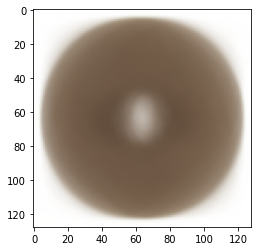

In [14]:
print('**** Non-Anomolus Average Image ****')
plt.imshow(np.sum(np.array(nonAnoImgData), axis = 0)/(len(nonAnoImgData)*255))
plt.show()

**** Anomolus Average Image ****


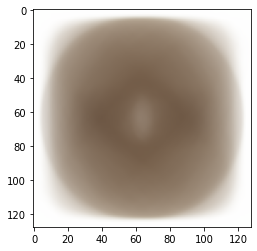

In [15]:
print('**** Anomolus Average Image ****')
plt.imshow(np.sum(np.array(anoImgData), axis = 0)/(len(anoImgData)*255))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


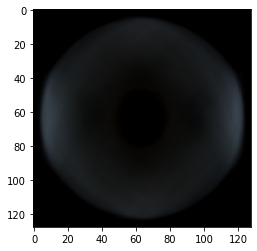

In [16]:
### Plotting image difference
plt.imshow(((np.sum(np.array(anoImgData), axis = 0)/(len(anoImgData)*255))-(np.sum(np.array(nonAnoImgData), axis = 0)/(len(nonAnoImgData)*255))), cmap='bwr')
plt.show()

###### Variance Image

**** Non-Anomolus Variance Image ****


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


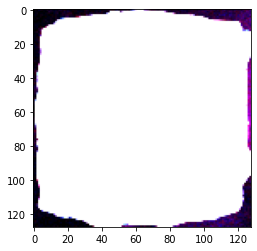

In [18]:
print('**** Non-Anomolus Variance Image ****')
plt.imshow(np.std(np.array(nonAnoImgData)*255, axis = 0))
plt.show()

**** Anomolus Variance Image ****


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


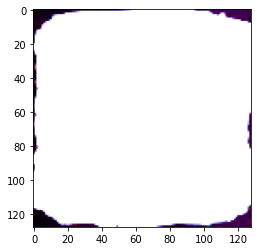

In [19]:
print('**** Anomolus Variance Image ****')
plt.imshow(np.std(np.array(anoImgData), axis = 0))
plt.show()

###### Checking sample pics for anomolus and non anomolous images

***** Non Anomolous ******


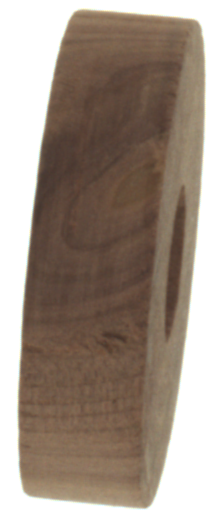

In [20]:
print('***** Non Anomolous ******')
Image.open('../cleanedData/nonanomaly/%s'%(nonAnomalyImg[0]))

***** Non Anomolous ******


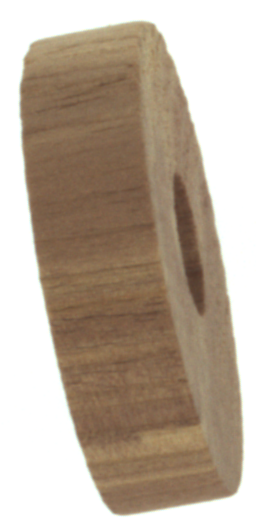

In [21]:
print('***** Non Anomolous ******')
Image.open('../cleanedData/nonanomaly/%s'%(nonAnomalyImg[6]))

***** Anomolous ******


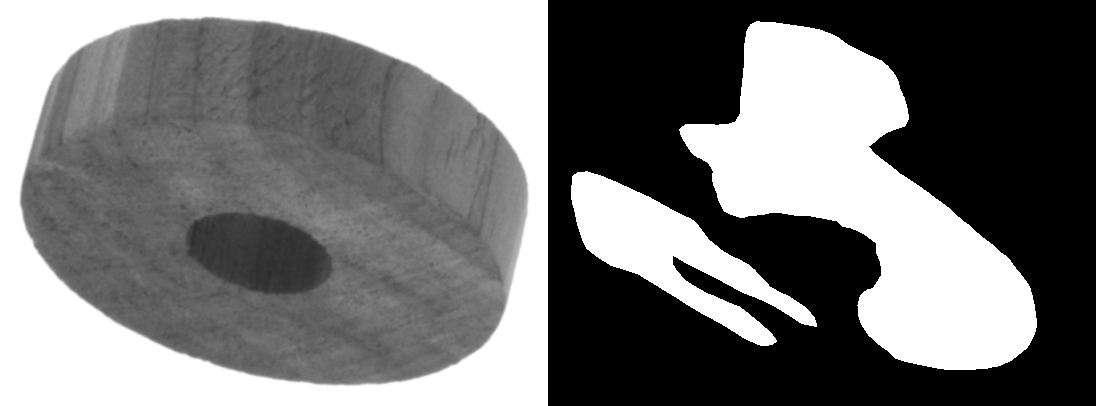

In [22]:
print('***** Anomolous ******')
i1 = Image.open('../cleanedData/anomaly/%s'%(anomalyImg[0]))
i2 = Image.open('../data/test/masks/AND/%s'%(anomalyImg[0]))

Image.fromarray(np.hstack((np.array(i1.convert("L")),np.array(i2))))

***** Anomolous ******


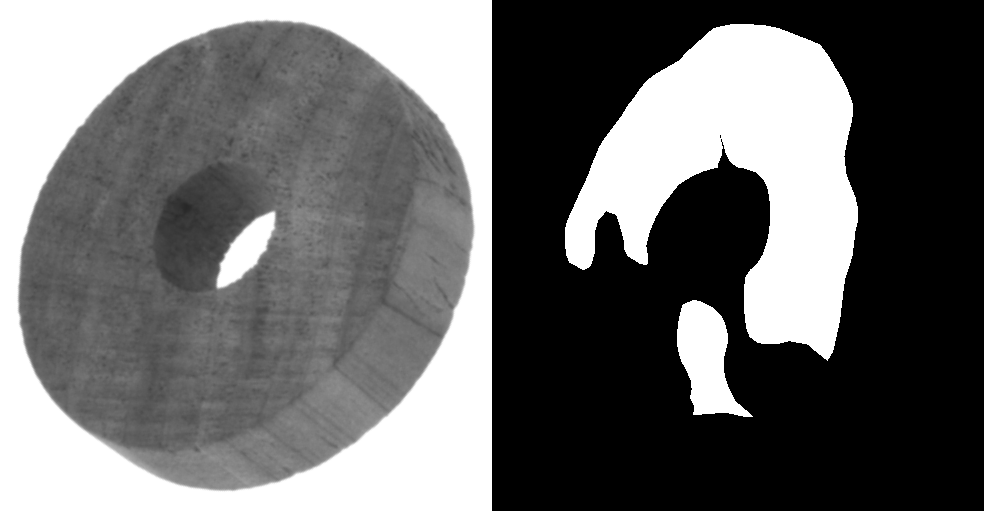

In [23]:
print('***** Anomolous ******')
i1 = Image.open('../cleanedData/anomaly/%s'%(anomalyImg[1]))
i2 = Image.open('../data/test/masks/AND/%s'%(anomalyImg[1]))

Image.fromarray(np.hstack((np.array(i1.convert("L")),np.array(i2))))

***** Anomolous ******


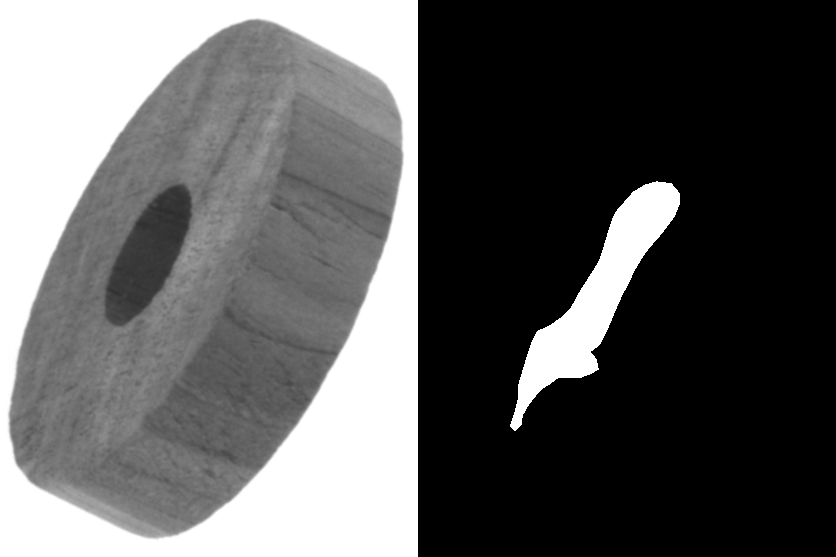

In [24]:
print('***** Anomolous ******')
i1 = Image.open('../cleanedData/anomaly/%s'%(anomalyImg[2]))
i2 = Image.open('../data/test/masks/AND/%s'%(anomalyImg[2]))

Image.fromarray(np.hstack((np.array(i1.convert("L")),np.array(i2))))

***** Anomolous ******


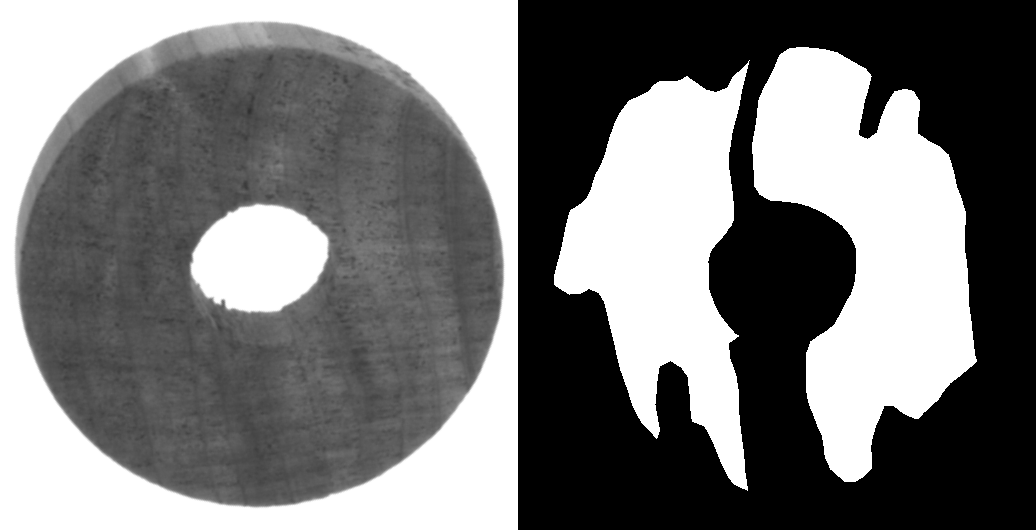

In [25]:
print('***** Anomolous ******')
i1 = Image.open('../cleanedData/anomaly/%s'%(anomalyImg[3]))
i2 = Image.open('../data/test/masks/AND/%s'%(anomalyImg[3]))

Image.fromarray(np.hstack((np.array(i1.convert("L")),np.array(i2))))

***** Anomolous ******


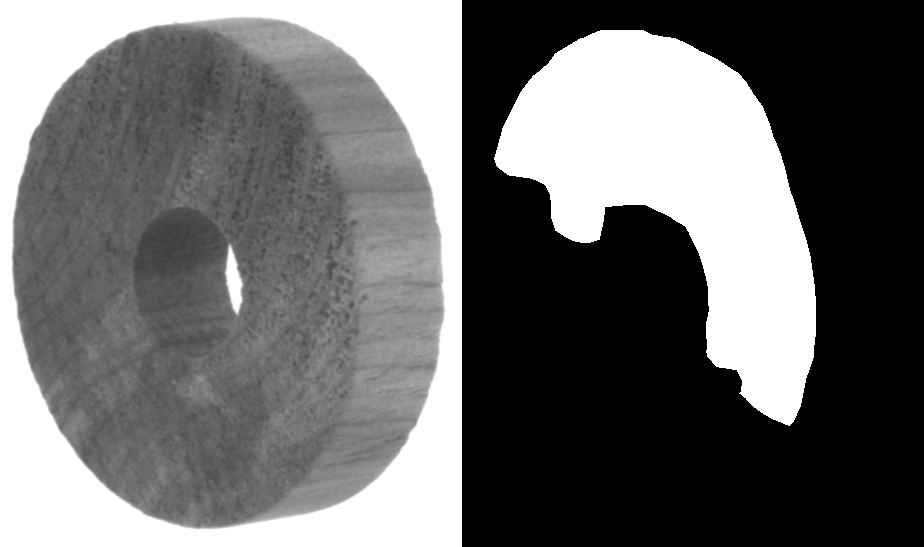

In [27]:
print('***** Anomolous ******')

i1 = Image.open('../cleanedData/anomaly/%s'%(anomalyImg[14]))
i2 = Image.open('../data/test/masks/AND/%s'%(anomalyImg[14]))

Image.fromarray(np.hstack((np.array(i1.convert("L")),np.array(i2))))

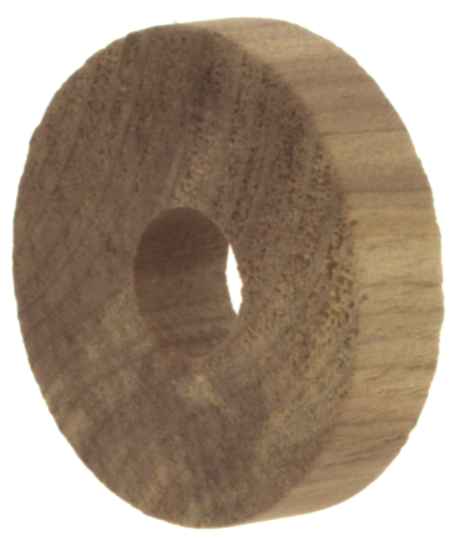

In [28]:
Image.open('../cleanedData/anomaly/%s'%(anomalyImg[14]))

###### Creating rotated images as we have relatively few images for model development

In [6]:
## Not rotating test images

for i in anomalyImg:
    im = Image.open('../cleanedData/anomaly/resized/%s'%(i))
    im.save('../cleanedData/anomaly_resized_rotated/%s'%(i))
#     for size in [90, 180, 270, 360]:
#         im.rotate(size).save('../cleanedData/anomaly_resized_rotated/%s_%s'%(size, i))

for i in nonAnomalyImg:
    im = Image.open('../cleanedData/nonanomaly/resized/%s'%(i))
    for size in [90, 180, 270, 360]:
        im.rotate(size).save('../cleanedData/nonanomaly_resized_rotated/%s_%s'%(size, i))

###### Edge Detection (Feature Engineering) using Prewitt kernel

In [7]:
import cv2 

In [8]:
#### Getting resized images
nonAnomalyImg = os.listdir('../cleanedData/nonanomaly_resized_rotated')
anomalyImg = os.listdir('../cleanedData/anomaly_resized_rotated')

#### Edge Detection
def edgeDection(i, imgLoc, saveLoc):
    img = cv2.imread('%s/%s'%(imgLoc, i))
    #img = ImageOps.grayscale(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #imageEdge = img.filter(ImageFilter.Kernel((3, 3), (-1, -1, -1, 0, 0,
           #                               0, 1, 1, 1), 1, 0))
    imageEdge = cv2.Canny(img, 30, 50) ## Canny edge detector
    cv2.imwrite(saveLoc+'/'+i, imageEdge)
    
#### Edge dection for Non-Anomalous images
for i in nonAnomalyImg:
    edgeDection(i, '../cleanedData/nonanomaly_resized_rotated', '../cleanedData/nonanomaly_resized_rotated_edge')
#### Edge dection for Anomalous images
for i in anomalyImg:
    edgeDection(i, '../cleanedData/anomaly_resized_rotated', '../cleanedData/anomaly_resized_rotated_edge')

###### Creating analysis ready dataset (In Tabluar format)

In [7]:
print(len(anomalyImg))
print(len(nonAnomalyImg))

327
3812


cleanedData\anomaly_resized_rotated

cleanedData\anomaly\resized

cleanedData\nonanomaly_resized_rotated

cleanedData\nonanomaly\resized

In [4]:
resizeLen=128

In [5]:
### Loading nonanomalous images
#### Images
nonAnomalyImg = os.listdir('../cleanedData/nonanomaly_resized_rotated_edge')
anomalyImg = os.listdir('../cleanedData/anomaly_resized_rotated_edge')
imageSize = resizeLen*resizeLen
nonAnoImageList = []
anoImageList = []

for i in nonAnomalyImg:
    #print(i)
    img = Image.open('%s/%s'%('../cleanedData/nonanomaly_resized_rotated_edge', i))
    imgArray = np.array(img)
    #imgArray = np.array(Image.open('%s/%s'%('../cleanedData/nonanomaly_resized_rotated_edge', i)))
    #print(imgArray.shape)
    ### Resizing and scaling images
    imgArray = imgArray.reshape((1, imageSize))
    imgArray = imgArray/255
    #print(imgArray.shape)
    nonAnoImageList.append(imgArray.tolist()[0])
    
for i in anomalyImg:
    
    imgArray = np.array(Image.open('%s/%s'%('../cleanedData/anomaly_resized_rotated_edge', i)))
    ### Resizing and scaling images
    imgArray = imgArray.reshape((1, imageSize))
    imgArray = imgArray/255
    #print(imgArray.shape)
    anoImageList.append(imgArray.tolist()[0])

In [6]:
len(nonAnoImageList[0])

16384

In [7]:
nonAnoImageDf = pd.DataFrame(nonAnoImageList)
anoImageDf = pd.DataFrame(anoImageList)

###### Building Data

In [8]:
xTrainCnnCat = np.array(nonAnoImageDf)
xTrainCnnCat= xTrainCnnCat.reshape((xTrainCnnCat.shape[0], xTrainCnnCat.shape[1], 1))
y_trainFrcstCat = np.array([1]*xTrainCnnCat.shape[0])

xTestCnnCat = np.array(anoImageDf)
xTestCnnCat= xTestCnnCat.reshape((xTestCnnCat.shape[0], xTestCnnCat.shape[1], 1))

In [9]:

#y_trainFrcstCat = np.array([1]*xTestCnnCat.shape[0])

### Auto Encoders

In [10]:
import keras
from keras import layers

In [11]:
128*128

16384

In [12]:
input_img = keras.Input(shape=(resizeLen*resizeLen, ))
encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)

decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(4096, activation='sigmoid')(decoded)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(xTrainCnnCat.reshape(3812 , resizeLen*resizeLen), xTrainCnnCat.reshape(3812 , resizeLen*resizeLen),
                epochs=100,
                batch_size=24,
                shuffle=True)


KeyboardInterrupt



In [ ]:
autoencoder.predict(xTestCnnCat).shape

In [ ]:
encoded_imgs = autoencoder.predict(xTestCnnCat)
decoded_imgs = autoencoder.predict(encoded_imgs)

In [ ]:
import matplotlib.pyplot as plt

- Train Loss

120/120 [==============================] - 1s 6ms/step


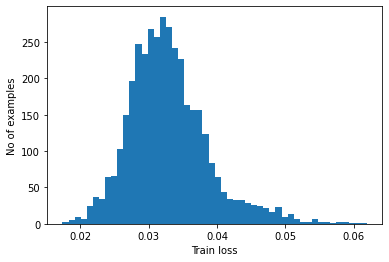

In [25]:
reconstructions = autoencoder.predict(xTrainCnnCat.reshape(3812 , resizeLen*resizeLen))
train_loss = tf.keras.losses.mae(reconstructions, xTrainCnnCat.reshape(3812 , resizeLen*resizeLen))

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [26]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.03868381182694292


- Test Loss

41/41 [==============================] - 0s 7ms/step


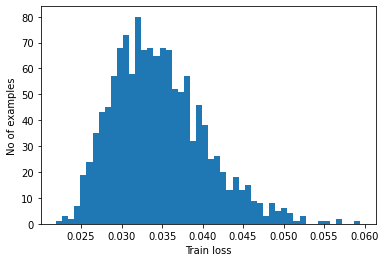

In [27]:
reconstructions = autoencoder.predict(xTestCnnCat.reshape(1308 , resizeLen*resizeLen))
test_loss = tf.keras.losses.mae(reconstructions, xTestCnnCat.reshape(1308 , resizeLen*resizeLen))

plt.hist(test_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [28]:
sum([1 if i>0.04945552907815284 else 0 for i in test_loss])/len(test_loss)

0.01529051987767584

In [29]:
sum([1 if i>0.04945552907815284 else 0 for i in train_loss])/len(train_loss)

0.013378803777544596

In [35]:
reconstructions[1].reshape(64, 64)*255

array([[254.99957, 254.99988, 254.99997, ..., 254.9952 , 254.99466,
        254.99686],
       [254.99994, 254.99995, 254.99991, ..., 254.99538, 254.99396,
        254.99614],
       [254.99982, 254.99992, 254.9998 , ..., 254.99582, 254.99625,
        254.99666],
       ...,
       [254.99721, 254.99739, 254.99687, ..., 254.99973, 254.99994,
        254.9999 ],
       [254.99625, 254.99464, 254.99649, ..., 254.99998, 254.99991,
        254.9999 ],
       [254.99767, 254.99597, 254.99612, ..., 254.99994, 254.99991,
        254.99954]], dtype=float32)

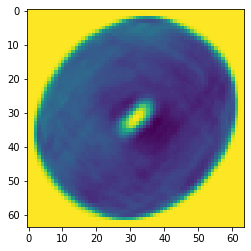

In [36]:
plt.imshow(reconstructions[1].reshape(64, 64)*255)

### Convolutional Autoencoders

In [23]:
import keras
from keras import layers

input_img = keras.Input(shape=(128, 128, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', )

In [15]:
xTrainCnnCat = np.array(nonAnoImageDf)
xTrainCnnCat= np.reshape(xTrainCnnCat, (len(xTrainCnnCat), 128, 128, 1))
#y_trainFrcstCat = np.array([1]*xTrainCnnCat.shape[0])

xTestCnnCat = np.array(anoImageDf)
xTestCnnCat= np.reshape(xTestCnnCat, (len(xTestCnnCat), 128, 128, 1))

In [25]:
xTestCnnCat.shape

(327, 128, 128, 1)

In [25]:
autoencoder.fit(xTrainCnnCat, xTrainCnnCat,
                epochs=30,
                batch_size=24,
                shuffle=True)

Epoch 1/30
159/159 [==============================] - 52s 273ms/step - loss: 0.6224
Epoch 2/30
159/159 [==============================] - 44s 273ms/step - loss: 0.4335
Epoch 3/30
159/159 [==============================] - 43s 273ms/step - loss: 0.3401
Epoch 4/30
159/159 [==============================] - 44s 277ms/step - loss: 0.2920
Epoch 5/30
159/159 [==============================] - 43s 272ms/step - loss: 0.2825
Epoch 6/30
159/159 [==============================] - 46s 290ms/step - loss: 0.2771
Epoch 7/30
159/159 [==============================] - 44s 279ms/step - loss: 0.2733
Epoch 8/30
159/159 [==============================] - 47s 295ms/step - loss: 0.2703
Epoch 9/30
159/159 [==============================] - 46s 288ms/step - loss: 0.2678
Epoch 10/30
159/159 [==============================] - 47s 295ms/step - loss: 0.2655
Epoch 11/30
159/159 [==============================] - 44s 278ms/step - loss: 0.2634
Epoch 12/30
159/159 [==============================] - 43s 270ms/step - lo

- Train loss

120/120 [==============================] - 7s 54ms/step


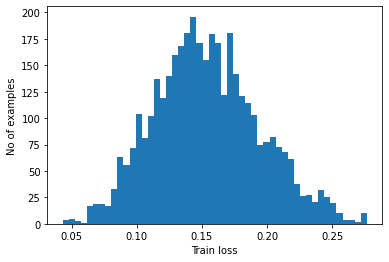

In [27]:
reconstructions = autoencoder.predict(xTrainCnnCat)
train_loss = tf.keras.losses.mae(reconstructions.reshape((3812, 128*128)), xTrainCnnCat.reshape((3812, 128*128)))

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

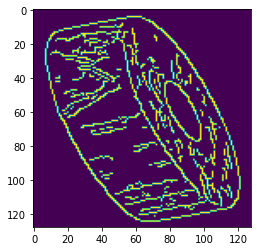

In [28]:
plt.imshow(xTrainCnnCat[100].reshape(128, 128)*255)

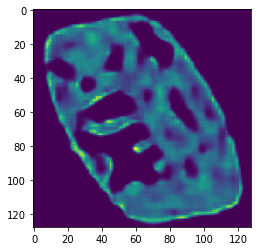

In [29]:
plt.imshow(reconstructions[100].reshape(128, 128)*255)

In [30]:
threshold = np.mean(train_loss) + (np.std(train_loss))
print("Threshold: ", threshold)

Threshold:  0.19452723240978956


- Test loss

11/11 [==============================] - 1s 46ms/step


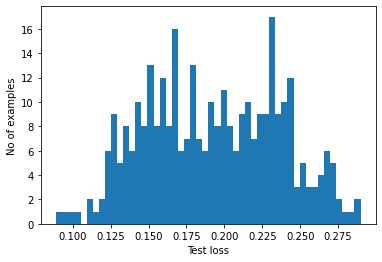

In [31]:
reconstructions = autoencoder.predict(xTestCnnCat)
test_loss = tf.keras.losses.mae(reconstructions.reshape((327, 128*128)), xTestCnnCat.reshape((327, 128*128)))

plt.hist(test_loss[None,:], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

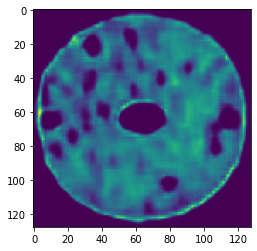

In [32]:
plt.imshow(reconstructions[6].reshape(128, 128)*255)

In [33]:
sum([1 if i>threshold else 0 for i in test_loss])/len(test_loss)

0.4831804281345566

In [34]:
sum([1 if i>threshold else 0 for i in train_loss])/len(train_loss)

0.16080797481636935

In [26]:
test_loss[0]

<tf.Tensor: shape=(), dtype=float64, numpy=0.22584202333462589>

### Train error vs test error with variation in loss threshold

In [35]:
resultsStd = pd.DataFrame()
threshold = []
trainError = []
testError = []

for i in range(0, 30, 1):
    thresholdValue = np.mean(train_loss) + i/10*(np.std(train_loss))
    #print(thresholdValue)
    threshold.append(thresholdValue)
    trainError.append(sum([1 if i>thresholdValue else 0 for i in train_loss])/len(train_loss))
    testError.append(sum([0 if i>thresholdValue else 1 for i in test_loss])/len(test_loss))

In [45]:
resultsStd['threshold'] = threshold
resultsStd['Train False Positive'] = trainError
resultsStd['Test False Negative'] = testError

In [46]:
resultsStd

,threshold,Train False Positive,Test False Negative
0,0.153888,0.483211,0.232416
1,0.157939,0.437566,0.269113
2,0.161990,0.400315,0.296636
3,0.166040,0.364638,0.330275
4,0.170091,0.335257,0.360856
5,0.174142,0.294071,0.379205
6,0.178193,0.263116,0.422018
7,0.182244,0.235047,0.449541
8,0.186295,0.211438,0.470948
9,0.190345,0.184942,0.492355


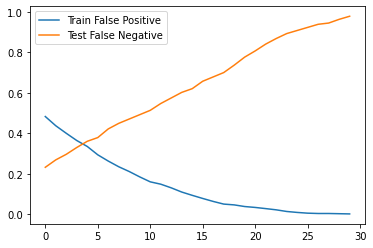

In [48]:
resultsStd[['Train False Positive', 'Test False Negative']].plot()
plt.show()

#### Saving model

In [36]:
# # JSON serializing model
# forecastJson = autoencoder.to_json()
# with open('../models/cnn_autoencoder_24032023'+'.json', "w") as json_file:
#     json_file.write(forecastJson)

# autoencoder.save_weights('../models/cnn_autoencoder_24032023'+'.h5')

In [42]:
threshold = np.mean(train_loss) + (np.std(train_loss))
print("Threshold: ", threshold)

Threshold:  0.19452723240978956


In [13]:
jFile = open('../models/cnn_autoencoder_24032023'+'.json', 'r')
loaded_model_json = jFile.read()
jFile.close()
autoencoder = model_from_json(loaded_model_json)
autoencoder.load_weights('../models/cnn_autoencoder_24032023'+'.h5')

In [16]:
reconstructions = autoencoder.predict(xTrainCnnCat)
train_loss = tf.keras.losses.mae(reconstructions.reshape((3812, 128*128)), xTrainCnnCat.reshape((3812, 128*128)))
reconstructions = autoencoder.predict(xTestCnnCat)
test_loss = tf.keras.losses.mae(reconstructions.reshape((327, 128*128)), xTestCnnCat.reshape((327, 128*128)))

11/11 [==============================] - 11s 130ms/step


In [17]:
threshold = np.mean(train_loss) + (np.std(train_loss))
print("Threshold: ", threshold)

Threshold:  0.19452723240978956


In [19]:
trainPred = [1 if i>threshold else 0 for i in train_loss]
testPred = [1 if i>threshold else 0 for i in test_loss]

In [22]:
trainResultDf = pd.DataFrame({'Img':nonAnomalyImg, 'Pred': trainPred, 'Act': [0]*len(trainPred)})
testResultDf = pd.DataFrame({'Img':anomalyImg, 'Pred': testPred, 'Act': [1]*len(testPred), 'fileName': anomalyImg, 'loss': test_loss})

In [24]:
testResultDf.to_csv('dsfds.csv')

In [51]:
trainResultDf.groupby(['Act']).sum()

,Pred
Act,
0,613


In [55]:
testResultDf.groupby(['Act']).sum()

,Pred
Act,
0,158


In [56]:
testResultDf.shape

(327, 3)

In [ ]:
[1 if i>threshold else 0 for i in train_loss]

In [52]:
trainResultDf.shape

(3812, 3)

In [58]:
testResultDf.to_csv('ret.csv')